# Stochastic Block Model with Poisson/Gamma observations

## Description
We are trying to do analysis on a weighted (positive integer weights), undirected network on interactions between characters in Game of Thrones using a Stochastic Block Model, see http://mikkelschmidt.dk/papers/schmidt2013spm.pdf, section II.a.1), 




The usually imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import pandas as pd
import networkx as nx

plt.style.use('ggplot')
%matplotlib inline

## Data import
Import of the datafiles. The contents of the dataset can be seen in the intial initial_notebook.

In short the data concist of an undireced netwwork between persons in the TV series games of thrones. 

We want to infer communities in the network based on the observed edges in the network. The observed data is represented through the adjacency matrix of the network of size $N \times N$ such that N is the observed number of nodes (ie. characters). Then $X[i,j] = w$ is the observed number of interactions, w, between character i and j. $X$ is symmetric, as the network is undirected.

In [9]:
# load nodes and edges from file
nodes = pd.read_csv('./data/got-s6-nodes.csv')
edges = pd.read_csv('./data/got-s6-edges.csv')

# initialize networkx graph object and add nodes and edges
G = nx.Graph(name='Game Of Thrones S06')
G.add_nodes_from(nodes['Id'])
edge_dict = [(x['Target'],x['Source'], {'weight' : x['Weight']}) for (_,x) in edges.iterrows()]
G.add_edges_from(edge_dict)

# Modelling

In [46]:
model_code="""
data {
        int<lower=1> N; // number of nodes
        int X[N,N]; // adjacency matrix
        int<lower=2> K; // number of groups
        vector[K] alpha; // prior for dirichlet distribution
        real a;          // priors on lambda
        real b;
} parameters {
        //int z[N]; // group belonging, encoded as integers - we cannot do this as z is integer latent variable!
        simplex[K] pi; // group sizes
        matrix<lower=0>[K,K] lambda; // rates between groups

} model {
        matrix[K,K] log_mix_prop; // log mixing proportions
        matrix[K,K] lps;
        
        pi ~ dirichlet(alpha); // prior on group sizes
        for (k1 in 1:K){
            for (k2 in 1:K) {
                lambda[k1,k2] ~ gamma(a,b);
            }
        }
        // cache mixing proportions
        for (k1 in 1:K) {
            for (k2 in 1:K) {
                log_mix_prop[k1, k2] = log(pi[k1]) + log(pi[k2]);
            }
        }
        
        // likelihood
        for (i in 1:N) {
            for (j in 1:N) {
                if (i == j) continue; // ignore diagonal
                
                lps = log_mix_prop; // reset log probs
                for (k1 in 1:K) {
                    for (k2 in 1:K) {
                        lps[k1, k2] += poisson_lpmf(X[i,j] | lambda[k1,k2]);
                    }
                }
                target += log_sum_exp(lps);
            }
        }
        
        
}
"""

In [47]:
sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9b8176e399c35195ff960fcdc2aca321 NOW.
/home/david/anaconda3/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp0ccb36on/stanfit4anon_model_9b8176e399c35195ff960fcdc2aca321_3555990978477491509.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


[[0 1 4 ... 0 0 5]
 [1 0 4 ... 0 0 0]
 [4 4 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 7 6]
 [0 0 0 ... 7 0 6]
 [5 0 0 ... 6 6 0]]


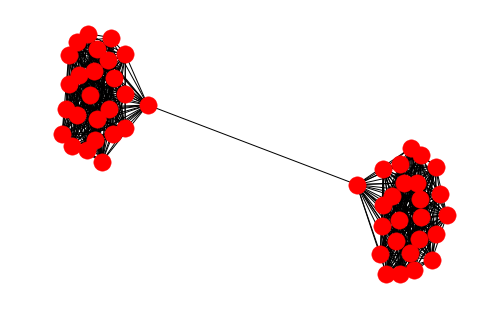

In [51]:
# Generate small network to test on

num_each = 50
G = nx.barbell_graph(num_each,0)
#nx.draw(G)

mat = nx.to_numpy_array(G, dtype=int)
rate1 = 5
rate2 = 8
mat1 = np.random.poisson(rate1, size=(num_each//2, num_each//2))
mat1 = np.tril(mat1) + np.tril(mat1,k=-1).T
mat2 = np.random.poisson(rate2, size=mat1.shape)
mat2 = np.tril(mat1) + np.tril(mat1, k=-1).T

mat = np.array(np.block([[mat1, np.zeros(mat1.shape, dtype=int)], [np.zeros(mat1.shape, dtype=int), mat2]]))
np.fill_diagonal(mat, 0)
mat[0,-1] = mat[-1,0] = np.random.poisson(8)


print(mat)
G = nx.from_numpy_array(mat)
nx.draw(G)

In [52]:
data = {'X' : mat, 'N' : mat.shape[0], 'K' : 2, 'alpha' : np.ones(2), 'a' : 7.5, 'b' : 1}
fit = sm.sampling(data=data, iter=10000, chains=1)

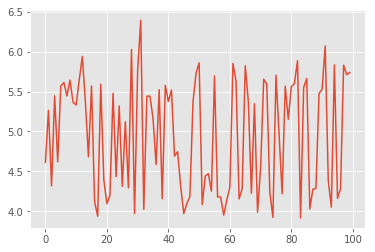

In [74]:
samples = fit.extract()
lambda_trace = samples['lambda']
plt.plot(lambda_trace[-100:,1,1])